# Analysis Chemical Space

In [1]:
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import helper
from modelforge.dataset.dataset import DatasetFactory, initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy

sns.set_theme()
sns.set_context("notebook")

#importlib.reload(helper)

<module 'helper' from '/home/shuaiy/workdir/modelforge-experiments/analysis/helper.py'>

In [2]:
seeds = [42, 43, 44, 45, 46]
seed_results = {
    42: "bad",
    43: "good",
    44: "bad",
    45: "bad",
    46: "good",
}
for i, seed in enumerate(seeds):
    # initialize datasets as in training
    dm = initialize_datamodule(
        dataset_name="fe_ii",
        version_select="latest",
        splitting_strategy=RandomRecordSplittingStrategy(
            seed=seed,
            split=[0.8, 0.1, 0.1],
        ),
        local_cache_dir="../cache",
    )
    train_dataset, val_dataset, test_dataset = (
            dm.train_dataset,
            dm.val_dataset,
            dm.test_dataset,
        )

    # gather per geometry properties
    gp = helper.PerGeometryProperties(
        seed,
        train_dataset,
        val_dataset,
        test_dataset,
        property_names=[
            "per_system_spin_state",
            "per_system_total_charge",
            "positions",
            "per_atom_force",
            "per_system_dipole_moment",
            "per_system_energy",
        ],
        dataset=dm.torch_dataset,
    )
    gp.prepare()

    # gather per compound properties
    cp = helper.PerCompoundProperties(
        seed,
        train_dataset,
        val_dataset,
        test_dataset,
        property_names=[
            "atomic_numbers",
        ],
        dataset=dm.torch_dataset,
    )
    cp.prepare()
    cp.update("number_of_atoms")

    # concatenate
    if i == 0:
        properties = {
            "per_geometry": gp.dataframe,
            "per_compound": cp.dataframe,
        }
    else:
        properties["per_geometry"] = pd.concat([properties["per_geometry"], gp.dataframe])
        properties["per_compound"] = pd.concat([properties["per_compound"], cp.dataframe])

2025-05-27 11:32:58.240 | DEBUG    | modelforge.dataset.fe_II:__init__:142 - Loading config data from /home/shuaiy/workdir/modelforge/modelforge/dataset/yaml_files/fe_II.yaml
2025-05-27 11:32:58.242 | INFO     | modelforge.dataset.fe_II:__init__:152 - Using the latest dataset: full_version_v1.1
2025-05-27 11:32:58.242 | INFO     | modelforge.dataset.dataset:create_dataset:919 - Creating dataset from https://zenodo.org/records/15264721/files/fe_II_v1.1.hdf5.gz
2025-05-27 11:32:58.242 | DEBUG    | modelforge.dataset.dataset:_from_file_cache:750 - Loading processed data from ../cache/Fe_II_dataset_processed_v1.1.npz generated on 2025-05-24 20:23:14.543693
2025-05-27 11:32:58.243 | DEBUG    | modelforge.dataset.dataset:_from_file_cache:753 - Properties of Interest in .npz file: ['atomic_numbers', 'energies', 'total_charge', 'spin_multiplicities', 'positions', 'forces']
2025-05-27 11:32:58.262 | INFO     | modelforge.dataset.dataset:prepare_data:1091 - Loading dataset statistics from disk: 

In [3]:
gd = properties["per_geometry"]
cd = properties["per_compound"]

In [10]:
properties["per_geometry"]

,dataset_type,seed,per_system_spin_state,per_system_total_charge,positions,per_atom_force,per_system_dipole_moment,per_system_energy
0,training,42,5,0,"[[-0.0006057139, -0.0015640892, 0.00052376743]...","[[-0.14717194, -0.045446172, 0.6913591], [18.6...","[0.0, 0.0, 0.0]",-810.320583
1,training,42,1,0,"[[-0.00034658445, 0.0006361791, 0.00055952853]...","[[-0.44504344, -0.47759238, -6.3567276], [58.7...","[0.0, 0.0, 0.0]",-1182.553105
2,training,42,1,0,"[[0.024958318, -0.021722604, 0.002284783], [-0...","[[-13.0447445, 10.526757, 41.157158], [114.656...","[0.0, 0.0, 0.0]",-1151.240687
3,training,42,1,0,"[[0.022486953, 0.020412255, 0.008068535], [-0....","[[1.5137942, -41.623463, 76.27002], [96.823074...","[0.0, 0.0, 0.0]",-1151.021473
4,training,42,1,0,"[[0.004475954, -0.007694325, -0.0018755527], [...","[[-1.4567616, 6.957344, 22.550814], [115.90289...","[0.0, 0.0, 0.0]",-1182.234533
...,...,...,...,...,...,...,...,...
28829,test,46,5,0,"[[-0.04285671, 7.0022674e-05, -0.00065555144],...","[[-163.39148, -2.8277633, 141.22792], [-285.05...","[0.0, 0.0, 0.0]",477.378556
28830,test,46,5,0,"[[-0.0443063, 0.00020800228, 0.0014401901], [-...","[[-202.0401, 28.321365, -88.11431], [-291.7571...","[0.0, 0.0, 0.0]",477.372551
28831,test,46,1,0,"[[-0.009862382, 0.0001723492, 5.5103108e-05], ...","[[-211.39304, -31.504662, 10.945606], [-119.45...","[0.0, 0.0, 0.0]",61.352338
28832,test,46,1,0,"[[0.009599067, 5.047093e-05, 0.00011055683], [...","[[195.54526, 31.20665, 13.626369], [111.92195,...","[0.0, 0.0, 0.0]",61.185724


In [111]:
properties["per_compound"]

,dataset_type,seed,atomic_numbers,number_of_atoms
0,training,42,"[26, 7, 7, 7, 7, 1, 7, 7, 6, 1, 6, 1, 6, 1, 6,...",55
1,training,42,"[26, 7, 7, 1, 1, 7, 1, 1, 7, 1, 1, 7, 1, 1, 8,...",46
2,training,42,"[26, 7, 7, 7, 7, 7, 7, 6, 1, 6, 1, 6, 1, 6, 6,...",66
3,training,42,"[26, 15, 15, 15, 15, 7, 7, 7, 7, 7, 7, 6, 6, 6...",55
4,training,42,"[26, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 1, 6, 1,...",63
...,...,...,...,...
379,test,46,"[6, 1, 6, 1, 6, 1, 6, 1, 6, 6, 6, 1, 1, 1, 6, ...",60
380,test,46,"[26, 8, 8, 8, 7, 7, 7, 7, 6, 1, 1, 6, 6, 1, 6,...",59
381,test,46,"[26, 17, 6, 1, 1, 6, 6, 6, 6, 1, 6, 1, 6, 6, 1...",67
382,test,46,"[26, 7, 7, 7, 7, 7, 7, 6, 1, 1, 6, 1, 6, 1, 6,...",55


## Plotting

In [87]:
for seed in seeds:
    number_of_geometries = len(gd[(gd["seed"] == seed)])
    number_of_training_geometries = len(gd[(gd["seed"] == seed) & (gd["dataset_type"] == "training")])
    number_of_validation_geometries = len(gd[(gd["seed"] == seed) & (gd["dataset_type"] == "validation")])
    number_of_test_geometries = len(gd[(gd["seed"] == seed) & (gd["dataset_type"] == "test")])

    print(f"For {seed_results[seed]} seed {seed}, the number of training geometries is {number_of_training_geometries}, which is {number_of_training_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print(f"For {seed_results[seed]} seed {seed}, the number of validation geometries is {number_of_validation_geometries}, which is {number_of_validation_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print(f"For {seed_results[seed]} seed {seed}, the number of test geometries is {number_of_test_geometries}, which is {number_of_test_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print("\n")

For bad seed 42, the number of training geometries is 24756, which is 85.85697440521606% of all 28834 geometries.
For bad seed 42, the number of validation geometries is 1784, which is 6.187140181729902% of all 28834 geometries.
For bad seed 42, the number of test geometries is 2294, which is 7.955885413054034% of all 28834 geometries.


For good seed 43, the number of training geometries is 25375, which is 88.00374557813693% of all 28834 geometries.
For good seed 43, the number of validation geometries is 1825, which is 6.329333425816744% of all 28834 geometries.
For good seed 43, the number of test geometries is 1634, which is 5.666920996046334% of all 28834 geometries.


For bad seed 44, the number of training geometries is 24080, which is 83.51251994173545% of all 28834 geometries.
For bad seed 44, the number of validation geometries is 2858, which is 9.911909551224248% of all 28834 geometries.
For bad seed 44, the number of test geometries is 1896, which is 6.5755705070403% of all

In [132]:
for seed in seeds:
    number_of_geometries = len(cd[(cd["seed"] == seed)])
    number_of_training_geometries = len(cd[(cd["seed"] == seed) & (cd["dataset_type"] == "training")])
    number_of_validation_geometries = len(cd[(cd["seed"] == seed) & (cd["dataset_type"] == "validation")])
    number_of_test_geometries = len(cd[(cd["seed"] == seed) & (cd["dataset_type"] == "test")])

    print(f"For {seed_results[seed]} seed {seed}, the number of training geometries is {number_of_training_geometries}, which is {number_of_training_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print(f"For {seed_results[seed]} seed {seed}, the number of validation geometries is {number_of_validation_geometries}, which is {number_of_validation_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print(f"For {seed_results[seed]} seed {seed}, the number of test geometries is {number_of_test_geometries}, which is {number_of_test_geometries/number_of_geometries*100}% of all {number_of_geometries} geometries.")
    print("\n")

For bad seed 42, the number of training geometries is 308, which is 80.20833333333334% of all 384 geometries.
For bad seed 42, the number of validation geometries is 38, which is 9.895833333333332% of all 384 geometries.
For bad seed 42, the number of test geometries is 38, which is 9.895833333333332% of all 384 geometries.


For good seed 43, the number of training geometries is 308, which is 80.20833333333334% of all 384 geometries.
For good seed 43, the number of validation geometries is 38, which is 9.895833333333332% of all 384 geometries.
For good seed 43, the number of test geometries is 38, which is 9.895833333333332% of all 384 geometries.


For bad seed 44, the number of training geometries is 308, which is 80.20833333333334% of all 384 geometries.
For bad seed 44, the number of validation geometries is 38, which is 9.895833333333332% of all 384 geometries.
For bad seed 44, the number of test geometries is 38, which is 9.895833333333332% of all 384 geometries.


For bad seed 

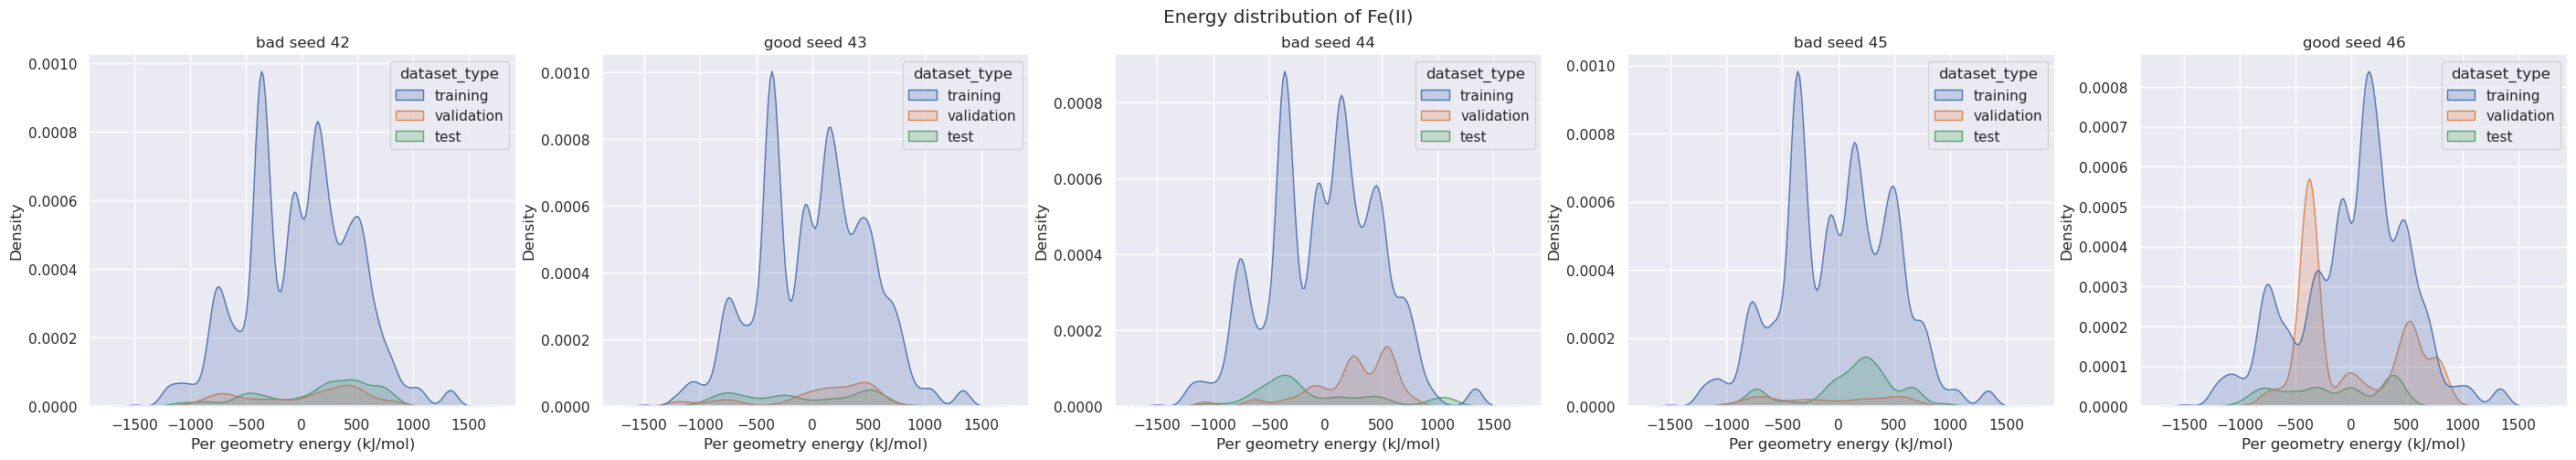

In [118]:
scalar_cols = [
    'seed',
    "dataset_type",
    'per_system_spin_state',
    'per_system_energy'
]
gd_scalar = gd[scalar_cols]

fig, axes = plt.subplots(1, 5, figsize=(35, 5))
fig.suptitle("Energy distribution of Fe(II)")

for i, seed in enumerate(seeds):
    g = sns.kdeplot(
        ax=axes[i],
        data=gd_scalar[gd_scalar["seed"] == seed],
        x="per_system_energy",
        hue="dataset_type",
        fill=True,
    )
    axes[i].set_xlabel("Per geometry energy (kJ/mol)")
    axes[i].set_title(f"{seed_results[seed]} seed {seed}")


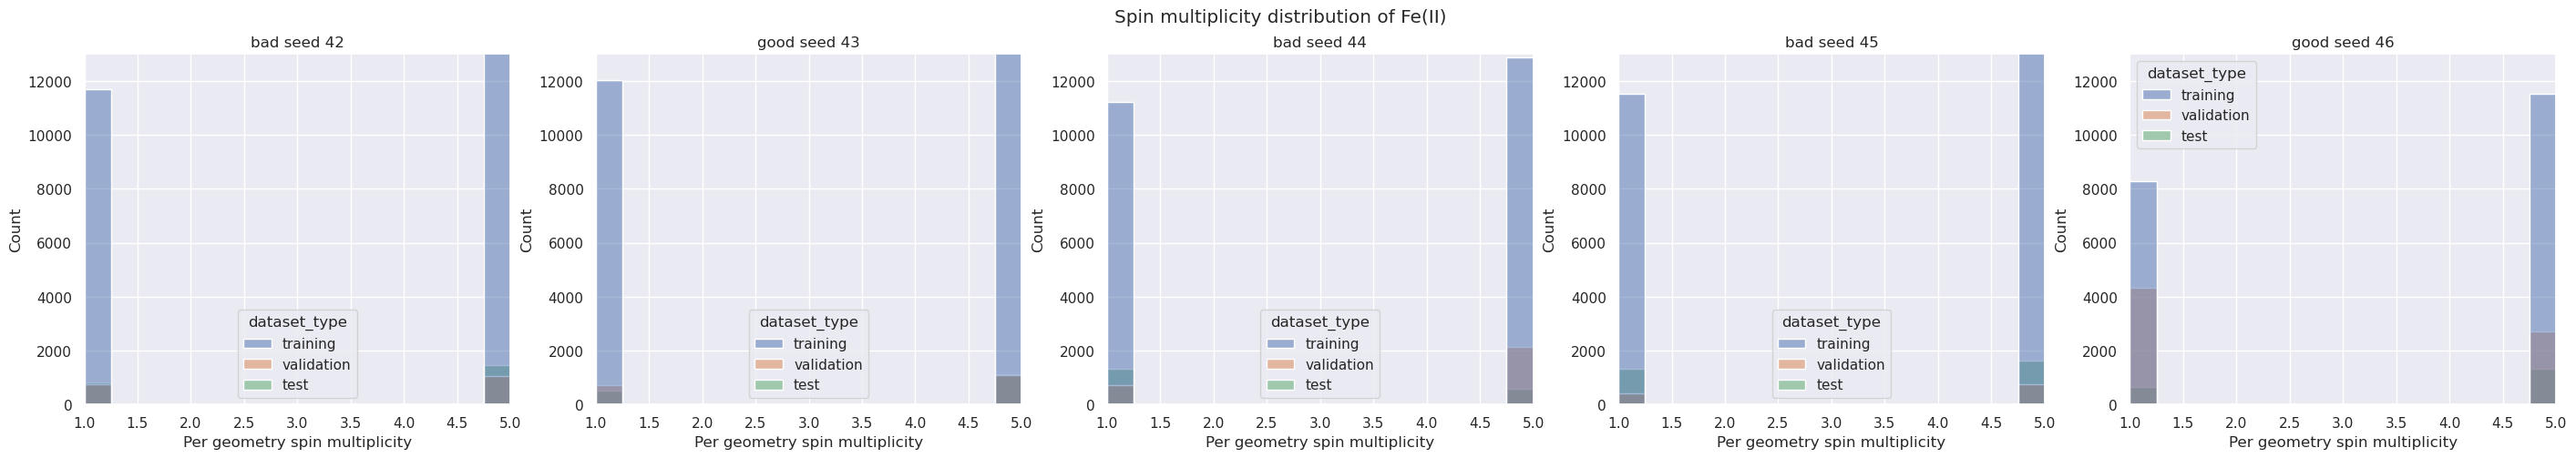

In [138]:
scalar_cols = [
    'seed',
    "dataset_type",
    'per_system_spin_state',
    'per_system_energy'
]
gd_scalar = gd[scalar_cols]

fig, axes = plt.subplots(1, 5, figsize=(35, 5))
fig.suptitle("Spin multiplicity distribution of Fe(II)")

for i, seed in enumerate(seeds):
    g = sns.histplot(
        ax=axes[i],
        data=gd_scalar[gd_scalar["seed"] == seed],
        x="per_system_spin_state",
        hue="dataset_type",
        fill=True,
    )
    axes[i].set_xlim(1, 5)
    axes[i].set_ylim(0, 13000)
    axes[i].set_xlabel("Per geometry spin multiplicity")
    axes[i].set_title(f"{seed_results[seed]} seed {seed}")


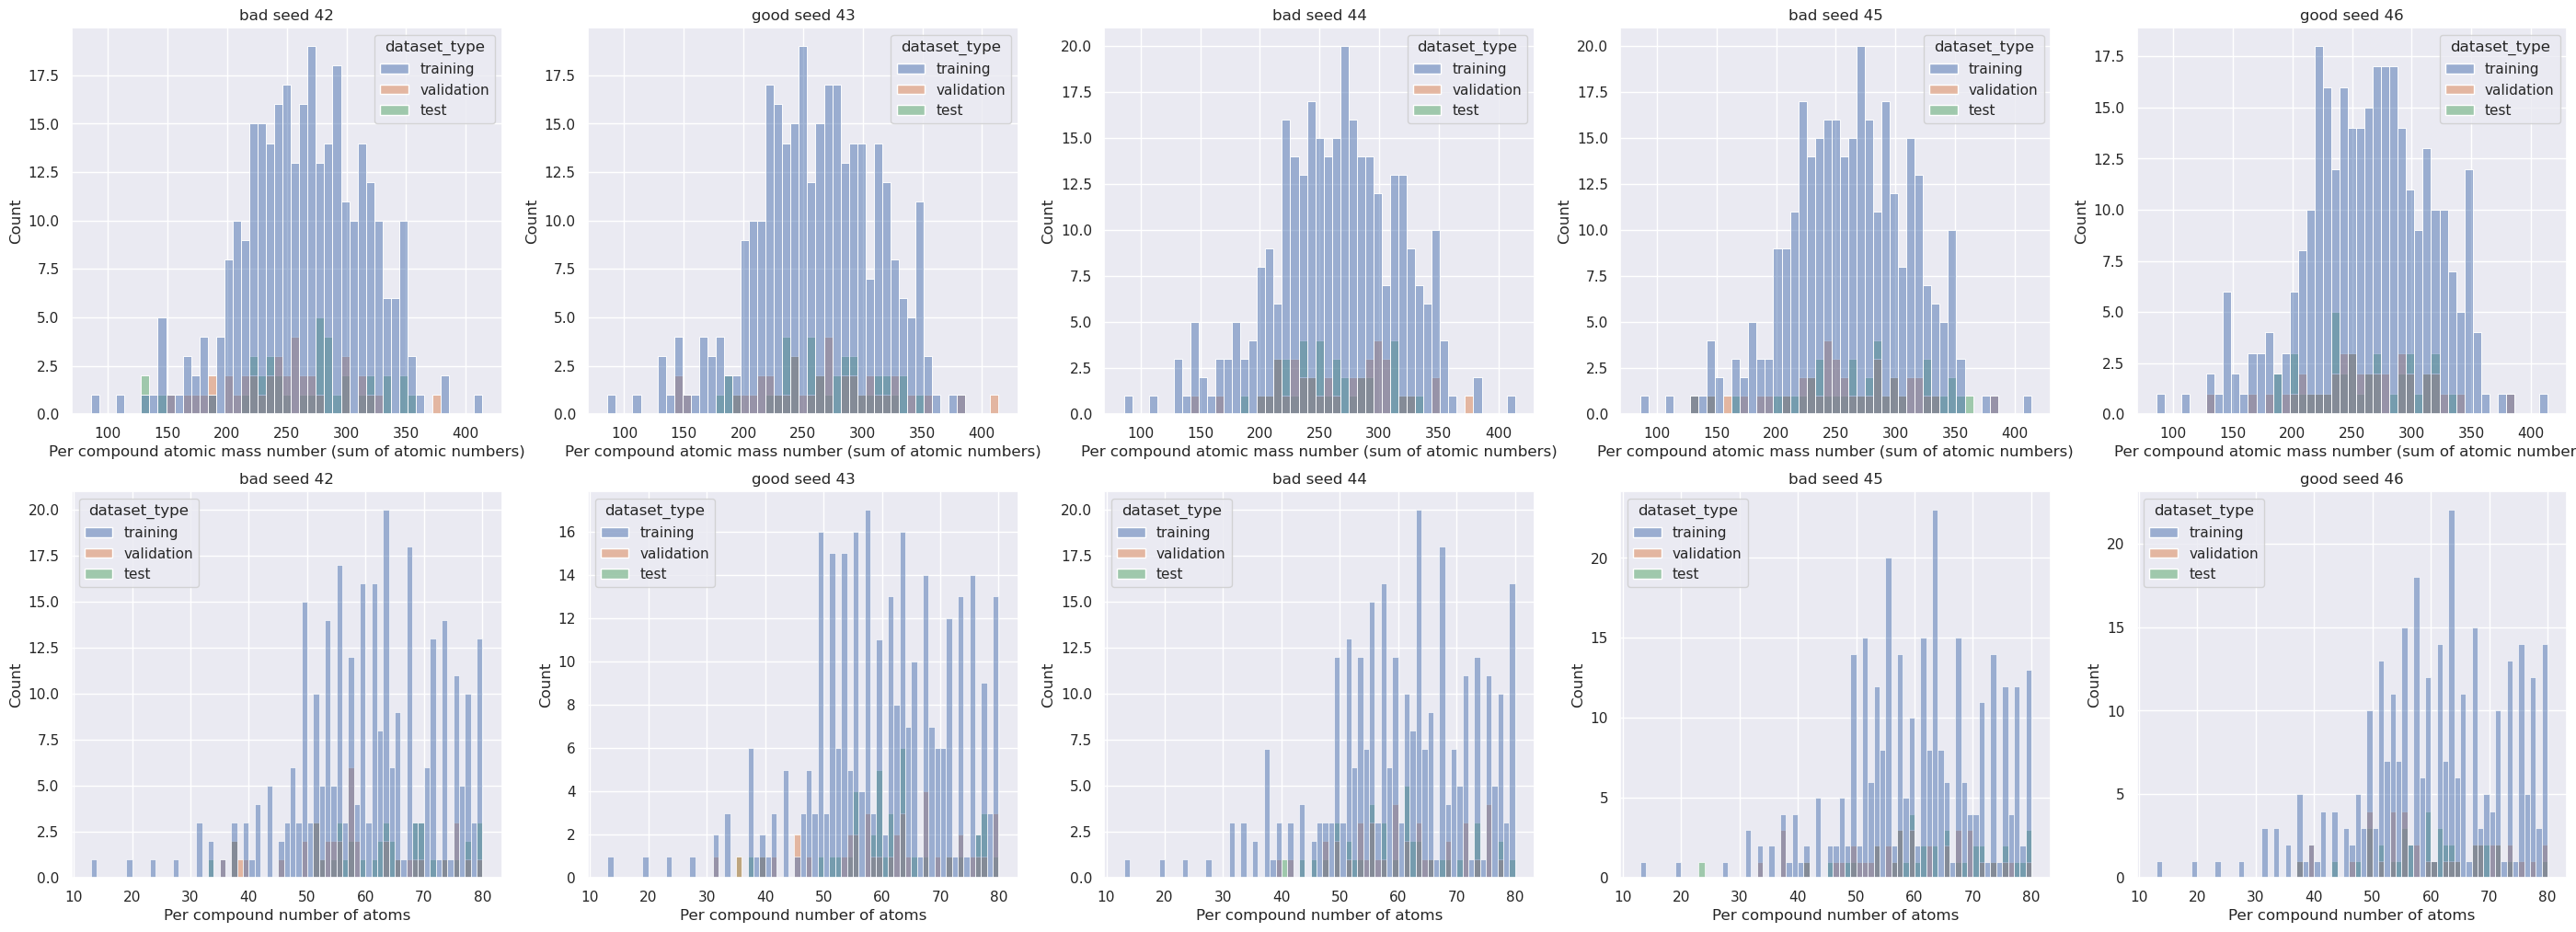

In [131]:
cd["atomic_mass_number"] = cd["atomic_numbers"].apply(np.sum)
scalar_cols = [
    'seed',
    "dataset_type",
    'atomic_mass_number',
    'number_of_atoms'
]
cd_scalar = cd[scalar_cols]

fig, axes = plt.subplots(2, 5, figsize=(35, 12))

for i, seed in enumerate(seeds):
    sns.histplot(
        ax=axes[0, i],
        data=cd_scalar[cd_scalar["seed"] == seed],
        x="atomic_mass_number",
        hue="dataset_type",
        binwidth=7,
        fill=True,
    )
    axes[0, i].set_xlabel("Per compound atomic mass number (sum of atomic numbers)")
    axes[0, i].set_title(f"{seed_results[seed]} seed {seed}")

    sns.histplot(
        ax=axes[1, i],
        data=cd_scalar[cd_scalar["seed"] == seed],
        x="number_of_atoms",
        hue="dataset_type",
        binwidth=1,
        fill=True,
    )
    axes[1, i].set_xlabel("Per compound number of atoms")
    axes[1, i].set_title(f"{seed_results[seed]} seed {seed}")
